In [ ]:
from __future__ import print_function

import sys
import numpy as np
from time import time
import matplotlib.pyplot as plt 

sys.path.append('/home/xilinx')
from pynq import Overlay
from pynq import allocate
from pynq import MMIO

ROM_SIZE = 0x2000 #8K

SOC_UP = 0x0000;
SOC_LA = 0x1000;
PL_AA_MB = 0x2000;
PL_AA = 0x2100;
SOC_IS = 0x3000;
SOC_AS = 0x4000;
SOC_CC = 0x5000;
PL_AS = 0x6000;
PL_IS = 0x7000;
PL_DMA = 0x8000;

TST_TOTAL_FRAME_NUM = 1
TST_FRAME_WIDTH     = 512
TST_FRAME_HEIGHT    = 512
TST_TOTAL_PIXEL_NUM = TST_FRAME_WIDTH * TST_FRAME_HEIGHT
TST_CTRL_DENOISE    = 0
TST_CTRL_EDGEDECT   = 2

TST_FRAME_WIDTH, TST_FRAME_HEIGHT, TST_TOTAL_PIXEL_NUM, TST_CTRL_DENOISE, TST_CTRL_EDGEDECT

In [ ]:
ol = Overlay("/home/xilinx/jupyter_notebooks/caravel_fpga.bit")
#ol.ip_dict

In [ ]:
ipOUTPIN = ol.output_pin_0
ipPS = ol.caravel_ps_0
# ipReadROMCODE = ol.read_romcode_0

#Add for SPI
ip_QSPI = ol.axi_quad_spi_0

In [ ]:
# ============================================
# AXI QuadSPI Control
# ============================================
XSP_DGIER_OFFSET = 0x1C
XSP_IISR_OFFSET = 0x20
XSP_IIER_OFFSET = 0x28
XSP_SRR_OFFSET = 0x40
XSP_CR_OFFSET = 0x60
XSP_SR_OFFSET = 0x64
XSP_DTR_OFFSET = 0x68
XSP_DRR_OFFSET = 0x6C
XSP_SSR_OFFSET = 0x70
XSP_TFO_OFFSET = 0x74
XSP_RFO_OFFSET = 0x78
XSP_REGISTERS = [0x40, 0x60, 0x64, 0x68, 0x6c, 0x70, 0x74, 0x78, 0x1c, 0x20, 0x28]

XSP_SRR_RESET_MASK = 0x0A
XSP_SR_TX_EMPTY_MASK = 0x04
XSP_SR_TX_FULL_MASK = 0x08
XSP_CR_TRANS_INHIBIT_MASK = 0x100
XSP_CR_LOOPBACK_MASK = 0x01
XSP_CR_ENABLE_MASK = 0x02
XSP_CR_MASTER_MODE_MASK = 0x04
XSP_CR_CLK_POLARITY_MASK = 0x08
XSP_CR_CLK_PHASE_MASK = 0x10
XSP_CR_TXFIFO_RESET_MASK = 0x20
XSP_CR_RXFIFO_RESET_MASK = 0x40
XSP_CR_MANUAL_SS_MASK = 0x80

SLAVE_NO_SELECTION = 0xFFFFFFFF

def cnfg(AxiQspi, clk_phase=0, clk_pol=0):
    print("Configure device")
    # Reset the SPI device
    AxiQspi.write(XSP_SRR_OFFSET, XSP_SRR_RESET_MASK)
    # Enable the transmit empty interrupt, which we use to determine progress on the transmission. 
    AxiQspi.write(XSP_IIER_OFFSET, XSP_SR_TX_EMPTY_MASK)
    # Disable the global IPIF interrupt
    AxiQspi.write(XSP_DGIER_OFFSET, 0)
    # Deselect the slave on the SPI bus
    AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)
    # Disable the transmitter, enable Manual Slave Select Assertion, put SPI controller into master mode, and enable it
    ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    ControlReg = ControlReg | XSP_CR_MASTER_MODE_MASK | XSP_CR_MANUAL_SS_MASK | XSP_CR_ENABLE_MASK | XSP_CR_TXFIFO_RESET_MASK | XSP_CR_RXFIFO_RESET_MASK
    AxiQspi.write(XSP_CR_OFFSET, ControlReg)
    ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    ControlReg = ControlReg & ~(XSP_CR_CLK_PHASE_MASK | XSP_CR_CLK_POLARITY_MASK) 
    if clk_phase == 1:
        ControlReg = ControlReg | XSP_CR_CLK_PHASE_MASK
    if clk_pol == 1:
        ControlReg = ControlReg | XSP_CR_CLK_POLARITY_MASK
    AxiQspi.write(XSP_CR_OFFSET, ControlReg)

    return 0

def write_tx_fifo(AxiQspi):
    #print("TransferData")
    ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    ControlReg = ControlReg & ~XSP_CR_TRANS_INHIBIT_MASK
    AxiQspi.write(XSP_CR_OFFSET, ControlReg)

    StatusReg = AxiQspi.read(XSP_SR_OFFSET)
    while (StatusReg & XSP_SR_TX_EMPTY_MASK) == 0:
        StatusReg = AxiQspi.read(XSP_SR_OFFSET)

    #print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(AxiQspi.read(XSP_RFO_OFFSET)))
    ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    ControlReg = ControlReg | XSP_CR_TRANS_INHIBIT_MASK
    AxiQspi.write(XSP_CR_OFFSET, ControlReg)


def read_rx_fifo(bypass_length, AxiQspi):
    #print("ReadResponse")
    resp = list()
    RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01
    
    # By pass the FIFO data during master issue command and address to slave device
    command_addr_length = bypass_length
    counter = 0    
    
    while RxFifoStatus == 0:
        #temp = AxiQspi.read(XSP_RFO_OFFSET)
        #print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(temp))
        temp = AxiQspi.read(XSP_DRR_OFFSET)
        #print('XSP_DRR_OFFSET  : 0x{0:08x}'.format(temp))    

        counter = counter + 1
        if(counter > command_addr_length):
            resp.append(temp)        
        
        RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01

    return resp

In [ ]:
# Check MPRJ_IO input/out/en
# 0x10 : Data signal of ps_mprj_in
#        bit 31~0 - ps_mprj_in[31:0] (Read/Write)
# 0x14 : Data signal of ps_mprj_in
#        bit 5~0 - ps_mprj_in[37:32] (Read/Write)
#        others  - reserved
# 0x1c : Data signal of ps_mprj_out
#        bit 31~0 - ps_mprj_out[31:0] (Read)
# 0x20 : Data signal of ps_mprj_out
#        bit 5~0 - ps_mprj_out[37:32] (Read)
#        others  - reserved
# 0x34 : Data signal of ps_mprj_en
#        bit 31~0 - ps_mprj_en[31:0] (Read)
# 0x38 : Data signal of ps_mprj_en
#        bit 5~0 - ps_mprj_en[37:32] (Read)
#        others  - reserved

print ("0x10 = ", hex(ipPS.read(0x10)))
print ("0x14 = ", hex(ipPS.read(0x14)))
print ("0x1c = ", hex(ipPS.read(0x1c)))
print ("0x20 = ", hex(ipPS.read(0x20)))
print ("0x34 = ", hex(ipPS.read(0x34)))
print ("0x38 = ", hex(ipPS.read(0x38)))


In [ ]:
# ============================================
# Release Reset First before passthrough mode
# ============================================
# Release Caravel reset
# 0x10 : Data signal of outpin_ctrl
#        bit 0  - outpin_ctrl[0] (Read/Write)
#        others - reserved
print (ipOUTPIN.read(0x10))
ipOUTPIN.write(0x10, 1)
print (ipOUTPIN.read(0x10))

In [ ]:
# ============================================
# Load firmware (fsic.hex) to memory npROM
# ============================================

# Create np with 8K/4 (4 bytes per index) size and be initiled to 0
npROM = np.zeros(ROM_SIZE >> 2, dtype=np.uint32)

npROM_index = 0
npROM_offset = 0
fiROM = open("/home/xilinx/jupyter_notebooks/fsic.hex", "r+")

for line in fiROM:
    # offset header
    if line.startswith('@'):
        # Ignore first char @
        npROM_offset = int(line[1:].strip(b'\x00'.decode()), base = 16)
        npROM_offset = npROM_offset >> 2 # 4byte per offset
        #print (npROM_offset)
        npROM_index = 0
        continue
    #print (line)

    # We suppose the data must be 32bit alignment
    buffer = 0
    bytecount = 0
    for line_byte in line.strip(b'\x00'.decode()).split():
        buffer += int(line_byte, base = 16) << (8 * bytecount)
        bytecount += 1
        # Collect 4 bytes, write to npROM
        if(bytecount == 4):
            npROM[npROM_offset + npROM_index] = buffer
            # Clear buffer and bytecount
            buffer = 0
            bytecount = 0
            npROM_index += 1
            #print (npROM_index)
            continue
    # Fill rest data if not alignment 4 bytes
    if (bytecount != 0):
        npROM[npROM_offset + npROM_index] = buffer
        npROM_index += 1
    
fiROM.close()

In [ ]:
# ============================================
# Enabling passthrou mode
# ============================================
cnfg(ip_QSPI)
# Passthrou mode - Write command
ip_QSPI.write(XSP_DTR_OFFSET, 0xC4) # Pass-Through (management)
ip_QSPI.write(XSP_DTR_OFFSET, 0x02) # Command: Write data to memory
ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Address_byte0
ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Address_byte1
ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Address_byte2

print('XSP_TFO_OFFSET  : 0x{0:08x}'.format(ip_QSPI.read(XSP_TFO_OFFSET)))

ip_QSPI.write(XSP_SSR_OFFSET, 0xFFFFFFFE)
write_tx_fifo(ip_QSPI)

print('XSP_TFO_OFFSET  : 0x{0:08x}'.format(ip_QSPI.read(XSP_TFO_OFFSET)))

In [ ]:
# ============================================
# Writing FW into SPIROM
# ============================================
# Fill up Tx_FIFO (16) for each write_tx_fifo
for index in range (ROM_SIZE >> 2):
     # 4 bytes alignment in npROM
    for byte_shift in range(4):
        tmp = int((npROM[index] >> (byte_shift * 8)) & 0xFF)
        ip_QSPI.write(XSP_DTR_OFFSET, tmp) # Write_data
    # TX_FIFO = 16, 4 * 4 = 16
    if((index % 3) == 3):
        write_tx_fifo(ip_QSPI)
        
# If rest data is not enough 16 bytes. Tx_FIFO is not empty
    StatusReg = ip_QSPI.read(XSP_SR_OFFSET)
    if ((StatusReg & XSP_SR_TX_EMPTY_MASK) == 0):
         write_tx_fifo(ip_QSPI)

In [ ]:
# ============================================
# Read SPIROM for testing
# ============================================
cnfg(ip_QSPI)

In [ ]:
# Test Passthrou mode - Read command
ip_QSPI.write(XSP_DTR_OFFSET, 0xC4) # Pass-Through (management)
ip_QSPI.write(XSP_DTR_OFFSET, 0x03) # Command: Read data from memory
ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Address_byte0
ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Address_byte1
ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Address_byte2
# Write dummy data
data_length = 0x8
for index in range(data_length):
    ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Dummy data

print('XSP_TFO_OFFSET  : 0x{0:08x}'.format(ip_QSPI.read(XSP_TFO_OFFSET)))
ip_QSPI.write(XSP_SSR_OFFSET, 0xFFFFFFFE)

In [ ]:
# Issue SPI master cycle
write_tx_fifo(ip_QSPI)

# Read the Rx data
rx_final = read_rx_fifo(5, ip_QSPI)
for data in rx_final:
    print (hex(data))

In [ ]:
# Write dummy data
data_length = 0x8
for index in range(data_length):
    ip_QSPI.write(XSP_DTR_OFFSET, 0x00) # Dummy data

print('XSP_TFO_OFFSET  : 0x{0:08x}'.format(ip_QSPI.read(XSP_TFO_OFFSET)))

In [ ]:
# Issue SPI master cycle
write_tx_fifo(ip_QSPI)

# Read the Rx data
rx_final = read_rx_fifo(0, ip_QSPI)
for data in rx_final:
    print (hex(data))

In [ ]:
# ============================================
# Exit passthrou mode, FW will be fetched
# ============================================
ip_QSPI.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)

In [ ]:
# Check MPRJ_IO input/out/en
# 0x10 : Data signal of ps_mprj_in
#        bit 31~0 - ps_mprj_in[31:0] (Read/Write)
# 0x14 : Data signal of ps_mprj_in
#        bit 5~0 - ps_mprj_in[37:32] (Read/Write)
#        others  - reserved
# 0x1c : Data signal of ps_mprj_out
#        bit 31~0 - ps_mprj_out[31:0] (Read)
# 0x20 : Data signal of ps_mprj_out
#        bit 5~0 - ps_mprj_out[37:32] (Read)
#        others  - reserved
# 0x34 : Data signal of ps_mprj_en
#        bit 31~0 - ps_mprj_en[31:0] (Read)
# 0x38 : Data signal of ps_mprj_en
#        bit 5~0 - ps_mprj_en[37:32] (Read)
#        others  - reserved

print ("0x10 = ", hex(ipPS.read(0x10)))
print ("0x14 = ", hex(ipPS.read(0x14)))
print ("0x1c = ", hex(ipPS.read(0x1c)))
print ("0x20 = ", hex(ipPS.read(0x20)))
print ("0x34 = ", hex(ipPS.read(0x34)))
print ("0x38 = ", hex(ipPS.read(0x38)))

In [ ]:
IP_BASE_ADDRESS = 0x60000000
ADDRESS_RANGE = 0x9000
mmio = MMIO(IP_BASE_ADDRESS, ADDRESS_RANGE)

In [ ]:
# ====================================================================================== #
# ====================================================================================== #
# PL_FSIC Side Configuration
# ====================================================================================== #
# ====================================================================================== #

In [ ]:
# PL_IS Config
ADDRESS_OFFSET = PL_IS #0x7000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
mmio.write(ADDRESS_OFFSET, 0x12345671)
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
mmio.write(ADDRESS_OFFSET, 0x12345673)
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# PL_DMA Config
ADDRESS_OFFSET = PL_DMA # 0x8000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))
print("mmio.read(ADDRESS_OFFSET+0x10): ", hex(mmio.read(ADDRESS_OFFSET+0x10)))
print("mmio.read(ADDRESS_OFFSET+0x20): ", hex(mmio.read(ADDRESS_OFFSET+0x20)))
print("mmio.read(ADDRESS_OFFSET+0x28): ", hex(mmio.read(ADDRESS_OFFSET+0x28)))
print("mmio.read(ADDRESS_OFFSET+0x30): ", hex(mmio.read(ADDRESS_OFFSET+0x30)))
print("mmio.read(ADDRESS_OFFSET+0x38): ", hex(mmio.read(ADDRESS_OFFSET+0x38)))
print("mmio.read(ADDRESS_OFFSET+0x3C): ", hex(mmio.read(ADDRESS_OFFSET+0x3C)))

In [ ]:
# PL_AS Config
ADDRESS_OFFSET = PL_AS # 0x6000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))
mmio.write(ADDRESS_OFFSET, 0x12345676)
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# PL_AA Config
ADDRESS_OFFSET = PL_AA # 0x2100
print("mmio.read(ADDRESS_OFFSET+0x00): ", hex(mmio.read(ADDRESS_OFFSET+0x00)))
print("mmio.read(ADDRESS_OFFSET+0x04): ", hex(mmio.read(ADDRESS_OFFSET+0x04))) 

In [ ]:
mmio.write(ADDRESS_OFFSET+0x00, 0x11111111)
mmio.write(ADDRESS_OFFSET+0x04, 0x22222222)

In [ ]:
# PL_AA_MB Mailbox
ADDRESS_OFFSET = PL_AA_MB # 0x2000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))
print("mmio.read(ADDRESS_OFFSET+0x04): ", hex(mmio.read(ADDRESS_OFFSET+0x04)))
print("mmio.read(ADDRESS_OFFSET+0x08): ", hex(mmio.read(ADDRESS_OFFSET+0x08)))
print("mmio.read(ADDRESS_OFFSET+0x0C): ", hex(mmio.read(ADDRESS_OFFSET+0x0C)))
print("mmio.read(ADDRESS_OFFSET+0x10): ", hex(mmio.read(ADDRESS_OFFSET+0x10)))
print("mmio.read(ADDRESS_OFFSET+0x14): ", hex(mmio.read(ADDRESS_OFFSET+0x14)))
print("mmio.read(ADDRESS_OFFSET+0x18): ", hex(mmio.read(ADDRESS_OFFSET+0x18)))
print("mmio.read(ADDRESS_OFFSET+0x1C): ", hex(mmio.read(ADDRESS_OFFSET+0x1C)))

In [ ]:
mmio.write(ADDRESS_OFFSET, 0x11111112)
mmio.write(ADDRESS_OFFSET+0x04, 0x22222223)
mmio.write(ADDRESS_OFFSET+0x08, 0x33333334)
mmio.write(ADDRESS_OFFSET+0x0C, 0x44444445)
mmio.write(ADDRESS_OFFSET+0x10, 0x55555556)
mmio.write(ADDRESS_OFFSET+0x14, 0x66666667)
mmio.write(ADDRESS_OFFSET+0x18, 0x77777778)
mmio.write(ADDRESS_OFFSET+0x1C, 0x88888889)

In [ ]:
# ====================================================================================== #
# ====================================================================================== #
# PL_Caravel Side Configuration
# ====================================================================================== #
# ====================================================================================== #

In [ ]:
# Caravel-IS Config
ADDRESS_OFFSET = SOC_IS # 0x3000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# Caravel-IS Config
ADDRESS_OFFSET = 0x3000
mmio.write(ADDRESS_OFFSET, 0x00000003)

In [ ]:
# Caravel-AS Config
ADDRESS_OFFSET = SOC_AS # 0x4000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# Caravel-AS Config
ADDRESS_OFFSET = SOC_AS # 0x4000
mmio.write(ADDRESS_OFFSET, 0x00000006)

In [ ]:
# Caravel-CC Config
ADDRESS_OFFSET = SOC_CC # 0x5000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# Caravel-CC Config
ADDRESS_OFFSET = SOC_CC # 0x5000
mmio.write(ADDRESS_OFFSET, 0x00000000)

In [ ]:
# Caravel-LA Config
ADDRESS_OFFSET = SOC_LA # 0x1000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# Caravel-UP Config
ADDRESS_OFFSET = SOC_UP # 0x0000
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET+0x04)))

In [ ]:
# ====================================================================================== #
# ====================================================================================== #
# SKIP LADMA Verification
# ====================================================================================== #
# ====================================================================================== #

In [ ]:
# # Allocation memory
# ladma_buf = allocate(shape=(1024,), dtype=np.uint32)
# print("ladma_buf.device_address: ", hex(ladma_buf.device_address))

# IP_BASE_ADDRESS = ladma_buf.device_address
# ADDRESS_RANGE = 0x1000
# buf_mmio = MMIO(IP_BASE_ADDRESS, ADDRESS_RANGE)
# # 0x00 : Control signals
# #        bit 0 - ap_start (R/W/COH)
# #        bit 1 - ap_done (R/COR)
# #        bit 2 - ap_idle (R)
# #        bit 3 - ap_ready (R/COR)
# # 0x10 : Buffer transfer done status register
# #        bit 0 - buffer transfer done status (R)
# # 0x20 : Buffer transfer done status clear register
# #        bit 0 - clear buffer transfer done status (R/W)
# # 0x28 : Buffer Length
# #        bit 31~0 - set buffer length (must 1024)
# # 0x30 : Triggered condition 
# #        bit 23~0 - set triggered condidtion (R/W)
# #        others  - reserved
# # 0x34 : Buffer Lower base address 
# #        bit 31~0 - (R/W)
# # 0x38 : Buffer High base address
# #        bit 31~0 - (R/W)
# # ladma Configuration
# ADDRESS_OFFSET = PL_DMA # 0x8000
# # exit clear operation
# mmio.write(ADDRESS_OFFSET + 0x20, 0x00000000)
# # set buffer length
# mmio.write(ADDRESS_OFFSET + 0x28, 0x00000400)
# # set trigger condition
# mmio.write(ADDRESS_OFFSET + 0x30, 0x00000000)
# # set buffer low
# mmio.write(ADDRESS_OFFSET + 0x38, ladma_buf.device_address)
# # set buffer high
# mmio.write(ADDRESS_OFFSET + 0x3C, 0x00000000)

In [ ]:
# ADDRESS_OFFSET = PL_DMA # 0x8000
# print("mmio.read(ADDRESS_OFFSET+0x00): ", hex(mmio.read(ADDRESS_OFFSET+0x00)))
# print("mmio.read(ADDRESS_OFFSET+0x10): ", hex(mmio.read(ADDRESS_OFFSET+0x10)))
# print("mmio.read(ADDRESS_OFFSET+0x20): ", hex(mmio.read(ADDRESS_OFFSET+0x20)))
# print("mmio.read(ADDRESS_OFFSET+0x28): ", hex(mmio.read(ADDRESS_OFFSET+0x28)))
# print("mmio.read(ADDRESS_OFFSET+0x30): ", hex(mmio.read(ADDRESS_OFFSET+0x30)))
# print("mmio.read(ADDRESS_OFFSET+0x38): ", hex(mmio.read(ADDRESS_OFFSET+0x38)))
# print("mmio.read(ADDRESS_OFFSET+0x3C): ", hex(mmio.read(ADDRESS_OFFSET+0x3C)))

In [ ]:
# # ladma Configuration
# ADDRESS_OFFSET = PL_DMA # 0x8000
# # set ap_start
# mmio.write(ADDRESS_OFFSET + 0x00, 0x00000001)

In [ ]:
# # enable la 0xFFFFFF
# ADDRESS_OFFSET = SOC_LA # 0x1000
# mmio.write(ADDRESS_OFFSET, 0x00FFFFFF)
# #print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))
# # select target UP
# ADDRESS_OFFSET = SOC_CC # 0x5000
# mmio.write(ADDRESS_OFFSET, 0x00000003)
# #print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# # ladma Configuration
# ADDRESS_OFFSET = PL_DMA # 0x8000
# while True:
#     if mmio.read(ADDRESS_OFFSET+0x10) == 0x01:
#         break
# print("mmio.read(ADDRESS_OFFSET+0x10): ", hex(mmio.read(ADDRESS_OFFSET+0x10)))

# # disable la 0x000000
# ADDRESS_OFFSET = SOC_LA # 0x1000
# mmio.write(ADDRESS_OFFSET, 0x00000000)
# # select fake UP
# ADDRESS_OFFSET = SOC_CC # 0x5000
# mmio.write(ADDRESS_OFFSET, 0x00000000) 

# ADDRESS_OFFSET = PL_DMA # 0x8000
# # clear buffer transfer done operation
# mmio.write(ADDRESS_OFFSET + 0x20, 0x00000001)
# # set ap_start
# mmio.write(ADDRESS_OFFSET + 0x00, 0x00000001)
# while True:
#     if mmio.read(ADDRESS_OFFSET+0x10) != 0x01:
#         break
# print("mmio.read(ADDRESS_OFFSET+0x10): ", hex(mmio.read(ADDRESS_OFFSET+0x10)))      

In [ ]:
# ADDRESS_OFFSET = PL_DMA # 0x8000
# print("mmio.read(ADDRESS_OFFSET+0x00): ", hex(mmio.read(ADDRESS_OFFSET+0x00)))
# print("mmio.read(ADDRESS_OFFSET+0x10): ", hex(mmio.read(ADDRESS_OFFSET+0x10)))
# print("mmio.read(ADDRESS_OFFSET+0x20): ", hex(mmio.read(ADDRESS_OFFSET+0x20)))
# print("mmio.read(ADDRESS_OFFSET+0x28): ", hex(mmio.read(ADDRESS_OFFSET+0x28)))
# print("mmio.read(ADDRESS_OFFSET+0x30): ", hex(mmio.read(ADDRESS_OFFSET+0x30)))
# print("mmio.read(ADDRESS_OFFSET+0x38): ", hex(mmio.read(ADDRESS_OFFSET+0x38)))
# print("mmio.read(ADDRESS_OFFSET+0x3C): ", hex(mmio.read(ADDRESS_OFFSET+0x3C)))

In [ ]:
# #dump la log to file
# file = open("simulate.log", "w")
# for i in range(0,0xFFF,4):
#     file.write('{:08x}'.format(buf_mmio.read(i))+"\n")
# file.close()

In [ ]:
# # ladma Configuration
# ADDRESS_OFFSET = PL_DMA # 0x8000
# # exit clear operation
# mmio.write(ADDRESS_OFFSET + 0x20, 0x00000000)
# # set ap_start again
# mmio.write(ADDRESS_OFFSET + 0x00, 0x00000001)

# # Confirming SOC_CC & SOC_LA Reading is still work
# ADDRESS_OFFSET = SOC_CC # 0x5000
# print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))
# print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# Translate simulate.log to output_new.vcd, which can be open by gtakwave
# %run read_la_data.py

In [ ]:
# ====================================================================================== #
# ====================================================================================== #
# START UPDMA VERC
# USE THE SAME FLOW AS TESTBENCH AS PART1
# ====================================================================================== #
# ====================================================================================== #

### Memory Map
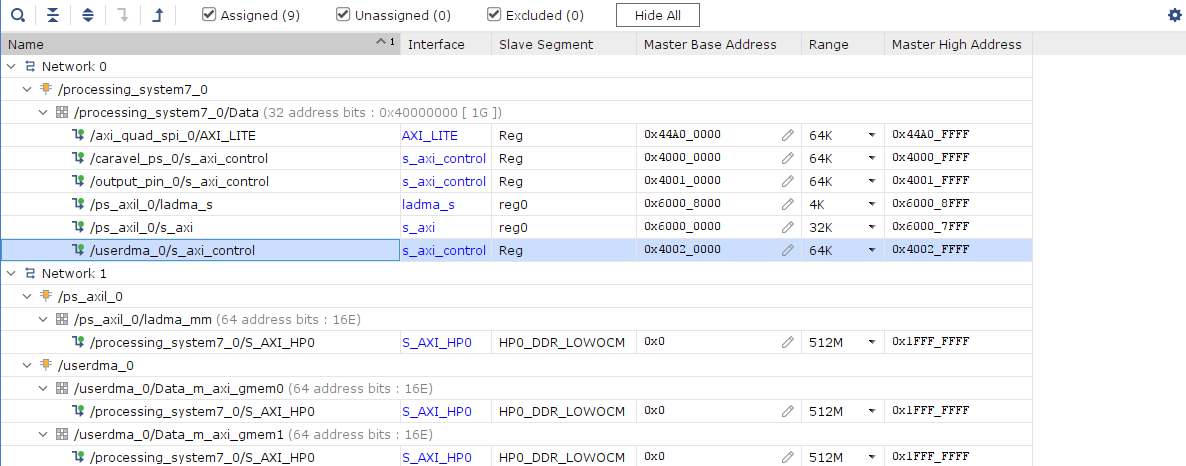

### Register Map
| Register          | WordOffset | StartBit | Length | ResetVal | Access | HADDRS | description                                                                |     |
| ----------------- | ---------- | -------- | ------ | -------- | ------ | ------ | -------------------------------------------------------------------------- | --- |
| reg_rst           | 0          | 0        | [0:0]  | 0        | R/W    | 00     | 1: reset edgedetect IP                                                     |     |
| reg_widthIn       | 1          | 0        | [10:0] | 640      | R/W    | 04     | frame width                                                                |     |
| reg_heightIn      | 2          | 0        | [9:0]  | 480      | R/W    | 08     | frame height                                                               |     |
| reg_ctrl_denoise  | 3          | 0        | [1:0]  | 0        | R/W    | 0C     | 0: Bypass Mode <br/>1: Gaussion Filter<br/>2:Median Filter                 |     |
| reg_ctrl_edgedect | 4          | 0        | [1:0]  | 0        | R/W    | 10     | 0: Bypass Mode <br/>1: Laplacian Filter<br/>2: Sobel Filter                |     |
| reg_IP_done       | 5          | 0        | [0:0]  | 0        | R/W    | 14     | Read it for checking if a frame is done. Write it for clearing this signal |     |


### Setup Flow (As verilog testbench)
1. Specify MMIO address
2. Load DMA
3. PL_UPDMA, s2m exit clear
4. PL_UPDMA, s2m disable to clear
5. PL_UPDMA, m2s exit clear
6. PL_UPDMA, m2s disable to clear
7. PL_UPDMA, s2m set buffer length
8. PL_UPDMA, s2m set buffer low
9. PL_UPDMA, s2m set buffer high
10. PL_UPDMA, set image width
11. PL_UPDMA, m2s set buffer low
12. PL_UPDMA, m2s set buffer high
13. PL_UPDMA, m2s set buffer length
14. SOC_CC, select IP user project
15. SOC_UP, set reg_rst to 1
16. SOC_UP, set reg_rst to 0
17. SOC_UP, set reg_widthIn
18. SOC_UP, set reg_heightOut
19. SOC_UP, set reg_ctrl_denoise
20. SOC_UP, set reg_ctrl_edgedect
21. SOC_CC, recheck and select IP user project
22. PL_UPDMA, set ap_start
23. PL_UPDMA, check ap_done in FIR IP

In [ ]:
mmio_UPDMA = MMIO(0x4002_0000, 0x0004_0000)   # Specify MMIO address
UPDMA_BUFI = allocate(shape=(TST_TOTAL_PIXEL_NUM,), dtype=np.uint32)   # Allocate input buf
UPDMA_BUFO = allocate(shape=(TST_TOTAL_PIXEL_NUM,), dtype=np.uint32)   # Allocate output buf
GOLDEN = allocate(shape=(TST_TOTAL_PIXEL_NUM,), dtype=np.uint32)   # Allocate golden buf

M2SBUF_ADDRESS = UPDMA_BUFI.device_address
S2MBUF_ADDRESS = UPDMA_BUFO.device_address


In [ ]:
# Load DMA
def read_hex_file_to_buffer(file_path, buffer):
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i >= TST_TOTAL_PIXEL_NUM:
                break
            buffer[i] = int(line.strip(), 16)

# Testpattern Select
def load_buffers(TST_CTRL_DENOISE, TST_CTRL_EDGEDECT):
    if 0 <= TST_CTRL_DENOISE <= 2 and 0 <= TST_CTRL_EDGEDECT <= 2:
        if TST_CTRL_DENOISE == 0:
            if TST_CTRL_EDGEDECT == 0:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/origin.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/00_origin.hex"
            elif TST_CTRL_EDGEDECT == 1:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/var_reduced.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/01_var_reduced.hex"
            elif TST_CTRL_EDGEDECT == 2:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/var_enhanced.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/02_var_enhanced.hex"
        elif TST_CTRL_DENOISE == 1:
            if TST_CTRL_EDGEDECT == 0:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/gaussion.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/10_gaussion.hex"
            elif TST_CTRL_EDGEDECT == 1:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/var_reduced_gaussion.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/11_var_reduced_gaussion.hex"
            elif TST_CTRL_EDGEDECT == 2:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/var_enhanced_gaussion.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/12_var_enhanced_gaussion.hex"
        elif TST_CTRL_DENOISE == 2:
            if TST_CTRL_EDGEDECT == 0:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/saltpepper.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/20_saltpepper.hex"
            elif TST_CTRL_EDGEDECT == 1:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/var_reduced_saltpepper.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/21_var_reduced_saltpepper.hex"
            elif TST_CTRL_EDGEDECT == 2:
                in_file_name = "/home/xilinx/jupyter_notebooks/pattern/var_enhanced_saltpepper.hex"
                out_file_name = "/home/xilinx/jupyter_notebooks/pattern/22_var_enhanced_saltpepper.hex"
    read_hex_file_to_buffer(in_file_name, UPDMA_BUFI)
    read_hex_file_to_buffer(out_file_name, GOLDEN)


load_buffers(TST_CTRL_DENOISE, TST_CTRL_EDGEDECT)

# Print the first few elements to verify
print(f"UPDMA_BUFI (first 10 elements):{UPDMA_BUFI[:10]}")
print(f"UPDMA_BUFO (first 10 elements):{GOLDEN[:10]}")

In [ ]:
mmio_UPDMA.write(0x0000_0020, 0x0000_0000)   # PL_UPDMA, s2m exit clear
mmio_UPDMA.write(0x0000_0030, 0x0000_0000)   # PL_UPDMA, s2m disable to clear
mmio_UPDMA.write(0x0000_0078, 0x0000_0000)   # PL_UPDMA, m2s exit clear
mmio_UPDMA.write(0x0000_0088, 0x0000_0000)   # PL_UPDMA, m2s disable to clear

mmio_UPDMA.write(0x0000_0028, TST_TOTAL_PIXEL_NUM)   # PL_UPDMA, s2m set buffer length
mmio_UPDMA.write(0x0000_0038, S2MBUF_ADDRESS)# PL_UPDMA, s2m set buffer low
mmio_UPDMA.write(0x0000_003C, 0x0000_0000)   # PL_UPDMA, s2m set buffer high

mmio_UPDMA.write(0x0000_0054, TST_FRAME_WIDTH)   # PL_UPDMA, set image width

mmio_UPDMA.write(0x0000_005C, M2SBUF_ADDRESS)# PL_UPDMA, m2s set buffer low
mmio_UPDMA.write(0x0000_0060, 0x0000_0000)   # PL_UPDMA, m2s set buffer high
mmio_UPDMA.write(0x0000_0080, TST_TOTAL_PIXEL_NUM)   # PL_UPDMA, m2s set buffer length

In [ ]:
print("mmio_UPDMA.read(0x0000_0020): ", hex(mmio_UPDMA.read(0x0000_0020)))
print("mmio_UPDMA.read(0x0000_0030): ", hex(mmio_UPDMA.read(0x0000_0030)))
print("mmio_UPDMA.read(0x0000_0078): ", hex(mmio_UPDMA.read(0x0000_0078)))
print("mmio_UPDMA.read(0x0000_0088): ", hex(mmio_UPDMA.read(0x0000_0088)))

print("mmio_UPDMA.read(0x0000_0028): ", hex(mmio_UPDMA.read(0x0000_0028)))
print("mmio_UPDMA.read(0x0000_0038): ", hex(mmio_UPDMA.read(0x0000_0038)))
print("mmio_UPDMA.read(0x0000_003C): ", hex(mmio_UPDMA.read(0x0000_003C)))

print("mmio_UPDMA.read(0x0000_0054): ", hex(mmio_UPDMA.read(0x0000_0054)))

print("mmio_UPDMA.read(0x0000_005C): ", hex(mmio_UPDMA.read(0x0000_005C)))
print("mmio_UPDMA.read(0x0000_0060): ", hex(mmio_UPDMA.read(0x0000_0060)))
print("mmio_UPDMA.read(0x0000_0080): ", hex(mmio_UPDMA.read(0x0000_0080)))

In [ ]:
ADDRESS_OFFSET = SOC_CC                     # SOC_CC, select IP user project
mmio.write(ADDRESS_OFFSET, 0x0000_0000)
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

ADDRESS_OFFSET = SOC_UP                     # SOC_UP, configure reg_rst to 1
mmio.write(ADDRESS_OFFSET + 0x00, 0x0000_0001)
print("mmio.read(ADDRESS_OFFSET + 0x00): ", hex(mmio.read(ADDRESS_OFFSET + 0x00)))

ADDRESS_OFFSET = SOC_UP                     # SOC_UP, configure reg_rst to 0
mmio.write(ADDRESS_OFFSET + 0x00, 0x0000_0000)
print("mmio.read(ADDRESS_OFFSET + 0x00): ", hex(mmio.read(ADDRESS_OFFSET + 0x00)))

ADDRESS_OFFSET = SOC_UP                     # SOC_UP, configure reg_widthIn
mmio.write(ADDRESS_OFFSET + 0x04, TST_FRAME_WIDTH)
print("mmio.read(ADDRESS_OFFSET + 0x04): ", hex(mmio.read(ADDRESS_OFFSET + 0x04)))

ADDRESS_OFFSET = SOC_UP                     # SOC_UP, configure reg_heightIn
mmio.write(ADDRESS_OFFSET + 0x08, TST_FRAME_HEIGHT)
print("mmio.read(ADDRESS_OFFSET + 0x08): ", hex(mmio.read(ADDRESS_OFFSET + 0x08)))

ADDRESS_OFFSET = SOC_UP                     # SOC_UP, configure reg_ctrl_denoise
mmio.write(ADDRESS_OFFSET + 0x0C, TST_CTRL_DENOISE)
print("mmio.read(ADDRESS_OFFSET + 0x0C): ", hex(mmio.read(ADDRESS_OFFSET + 0x0C)))

ADDRESS_OFFSET = SOC_UP                     # SOC_UP, configure reg_ctrl_edgedect
mmio.write(ADDRESS_OFFSET + 0x10, TST_CTRL_EDGEDECT)
print("mmio.read(ADDRESS_OFFSET + 0x10): ", hex(mmio.read(ADDRESS_OFFSET + 0x10)))

ADDRESS_OFFSET = SOC_CC                     # SOC_CC, recheck user project sel
mmio.write(ADDRESS_OFFSET, 0x0000_0000)
print("mmio.read(ADDRESS_OFFSET): ", hex(mmio.read(ADDRESS_OFFSET)))

In [ ]:
# ADDRESS_OFFSET = SOC_UP                     # SOC_UP, configure ap_start in FIR IP
# mmio.write(ADDRESS_OFFSET, 0x0000_0001)
mmio_UPDMA.write(0x0000_0000, 0x0000_0001)  # PL_UPDMA, set ap_start

In [ ]:
while True:                                 # PL_UPDMA, polling ap_done        
    if mmio_UPDMA.read(0x0000_0010)==0x0000_0001:
        break

In [ ]:
def write_buffer_to_hex_file(buffer, file_path):
    with open(file_path, 'w') as file:
        for value in buffer:
            file.write(f'{value:02x}\n')

output_hex_file_path = 'output.hex'
write_buffer_to_hex_file(UPDMA_BUFO, output_hex_file_path)

with open(output_hex_file_path, 'r') as file:
    for _ in range(10):
        print(file.readline().strip())

In [ ]:
# for row in TST_FRAME_HEIGHT:
#     for col in TST_FRAME_WIDTH:
#         print(f'{UPDMA_BUFO[row*TST_FRAME_WIDTH+col]:02x}', end=("\n" if col==TST_FRAME_WIDTH-1 else " "))